In [41]:
%matplotlib inline

☐ re-visit sources - B1-a, DK Cha, TMC1, WL12, L1455-IRS, L1014, and IRAS03301.
    - aperture failed to converage - TMC1, WL12, L1014, and IRAS03301.
    - aperture too big - B1-a (61.8)
        - increasing the aperture from 31.8" to 61.8" does increase the noise seen in the shorter wavelength, but not very significant.  The auto-match routine matches the PACS and SPIRE spectrum at the longest wavelength of PACS, but increasing the aperture size only slightly increase the flux at the shorter wavelength.
    - unknown reason - DKCha (31.8), L1455-IRS3 (24.8)
        - DKCha solved.  The problem is that there are wavelength points that appear to be NaN but were set to be zero as part of the 1D reduction.  It results in missing flux at certain wavelength points.  The solution is to flag any wavelength point that has NaN value.
        - L1455-IRS3: Nothing seems wrong in the 1D extraction.  The same noisy feature is also found in the raw Herschel product.  Maybe it is the reduction pipeline that causes the difference.

In [33]:
# Source info
obj_list = [['TMC1','1342225803','1342225804','1342250512'],
            ['WL12','1342228187','1342228188','1342251290'],
            ['L1014','1342208911','1342208912','1342245857'],
            ['IRAS03301','1342215668','1342216181','1342249477'],
            ['B1-a','1342216182','1342216183','1342249475'],
            ['DKCha','1342188039','1342188040','1342254037'],
            ['L1455-IRS3','1342204122','1342204123','1342249474']]
pacsdatadir = '/scratch/CDF_PACS_HSA/'
# pacsdatadir = '/Users/yaolun/test/'
outdir = '/home/bettyjo/yaolun/test/'
# outdir = '/Users/yaolun/test/'

In [73]:
def cdfPacs1d(obsid, datadir, outdir, objname, aper_size=31.8, suffix='hsa',
              auto_match=False, threshold=0.05, aper_step=10, max_iter=20, print_all_path=0, idl=False, fitting=False):
    """
    obsid  = [obsid1, obsid2]
    outdir: The output directory for the source.  e.g. /CDF_archive/BHR71/
    suffix: 'hsa' for data directly acquired from HSA.  Should probably get rid of it in the end.
            But now it distinguishes the recent results from old CDF reduction.
    """
    import numpy as np
    # to avoid X server error
    import matplotlib as mpl
    mpl.use('Agg')
    from astropy.io import ascii, fits
    import matplotlib.pyplot as plt
    import sys
    import os
    sys.path.append(os.path.expanduser('~')+'/programs/spectra_analysis/')
    sys.path.append(os.path.expanduser('~')+'/programs/misc/')
#     from pacs_weight import pacs_weight
#     from PacsSpire_SpecMatch import PacsSpire_SpecMatch

    def pacs_weight(cubedir, obj, aper_size, outdir, fits_for_header,
                    suffix='', plot=None, wavelimit=None):
        """
        cubedir: The directory contains the flux and coordinates of each spaxel in ASCII files
        plot: If a path is given, then it will make a plot of an overview of aperture_masked
              spaxel configuration.
        fits_for_header: The FITS file contains the required keywords -
                         CROTA2, CDELT1 or CDELT2
        """
        from astropy.io import ascii, fits
        import numpy as np

        def CircularAperture(x, y, r, pix=10000.):

            grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
            grid_x = grid_x - (pix-1)/2.
            grid_y = grid_y - (pix-1)/2.
            grid_dist = ((grid_x-x)**2+(grid_y-y)**2)**0.5
            aperture = np.where(grid_dist <= r, np.full((int(pix), int(pix)), 1, dtype=int), 0)

            return aperture

        def Total_MaskedAperture(aperture, mask):

            aperture_masked = np.where(mask != 0, aperture, 0)

            return aperture_masked, np.sum(aperture_masked)

        def Mask(x, y, edge, rot, pix=10000.):
            from scipy.ndimage.interpolation import rotate

            init_arr = np.full((int(pix), int(pix)), 1, dtype=int)
            grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))

            # RA offset (x) and Dec offset (y) need to be rotated, because the spaxels are rotated.
            rotMatrix = np.array([[np.cos(np.radians(rot)), -np.sin(np.radians(rot))],
                                  [np.sin(np.radians(rot)),  np.cos(np.radians(rot))]])
            coord_rot = np.squeeze(np.dot(rotMatrix, np.array([x,y]).reshape(2,1)))

            dist_x = abs(grid_x - (pix-1)/2. - coord_rot[0])
            dist_y = abs(grid_y - (pix-1)/2. - coord_rot[1])

            aper_trim = np.where((dist_x <= edge/2.) & (dist_y <= edge/2.), init_arr, 0)

            return aper_trim

        mean_coord = {'RA':[], 'Dec':[]}
        coord = {'RA':[], 'Dec':[]}
        foo_cen = ascii.read(cubedir+obj+'_pacs_pixel13_'+suffix+'_coord.txt')
        cen_ra, cen_dec = foo_cen['RA(deg)'][0], foo_cen['Dec(deg)'][0]
        mean_cen_ra, mean_cen_dec = np.mean(foo_cen['RA(deg)']), np.mean(foo_cen['Dec(deg)'])

        for i in range(1,26):
            foo = ascii.read(cubedir+obj+'_pacs_pixel'+str(i)+'_'+suffix+'_coord.txt')
            mean_coord['RA'].append((np.mean(foo['RA(deg)']) - mean_cen_ra)*np.cos(np.radians(mean_cen_dec))*3600.)
            mean_coord['Dec'].append((np.mean(foo['Dec(deg)']) - mean_cen_dec)*3600.)

            coord['RA'].append((foo['RA(deg)'][0]-cen_ra)*np.cos(np.radians(cen_dec))*3600.)
            coord['Dec'].append((foo['Dec(deg)'][0]-cen_dec)*3600.)

        # do 60" x 60"
        pix = 1000.
        factor = pix/60.
        weight = []
        aperture = CircularAperture(0, 0, aper_size/2.*factor, pix=pix)
        pix_size = abs(fits.open(fits_for_header)[1].header['CDELT1']*3600)
        ideal = (pix_size*factor)**2

        rot_angle = fits.open(fits_for_header)[1].header['CROTA2']

        a = np.full((int(pix), int(pix)), 0)
        for i in range(0,25):
            ra = coord['RA'][i]
            dec = coord['Dec'][i]
            masked_arr, arr_sum = Total_MaskedAperture(aperture, Mask(ra*factor, dec*factor, pix_size*factor, rot_angle, pix=pix))
            a = a + masked_arr
            weight.append(arr_sum)

        # somehow there is about 1% error even if the whole spaxel should be within the circular aperture
        for i in range(len(weight)):
            if np.abs(weight[i]/ideal) >= 0.99:
                weight[i] = 1
            else:
                weight[i] = weight[i]/ideal

        # plot
        if plot != None:
            import matplotlib.pyplot as plt
            from scipy.ndimage.interpolation import rotate

            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            factor_rot = len(rotate(a, -rot_angle)[:,0])/pix

            ax.imshow(rotate(a, -rot_angle), extent=[-30*factor_rot,30*factor_rot,-30*factor_rot,30*factor_rot],
                      cmap='viridis', vmax=2)

            [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
            ax.minorticks_on()
            ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
            ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
            ax.set_xlabel('RA offset [arcsec]', fontsize=18)
            ax.set_ylabel('Dec offset [arcsec]', fontsize=18)

            fig.savefig(plot+'pacs_masked.pdf', format='pdf', dpo=300, bbox_inches='tight')

#         # visualize the weight
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
        
#         ax.imshow(np.reshape(weight, (5,5)))

        # get the flux of each spaxel and apply the weighting
        foo_cen = ascii.read(cubedir+obj+'_pacs_pixel13_'+suffix+'.txt')
        if wavelimit == None:
            trimmer = np.ones_like(foo_cen['Wavelength(um)'], dtype=bool)
        else:
            trimmer = (foo_cen['Wavelength(um)'] > wavelimit[0]) & (foo_cen['Wavelength(um)'] < wavelimit[1])

        wl = foo_cen['Wavelength(um)'][trimmer]
        flux = np.zeros_like(foo_cen['Flux_Density(Jy)'][trimmer])

        for i in range(1,26):
            foo = ascii.read(cubedir+obj+'_pacs_pixel'+str(i)+'_'+suffix+'.txt')
            # set NaN values to zero
#             foo['Flux_Density(Jy)'][np.isnan(foo['Flux_Density(Jy)'])] = 0

            flux = flux + foo['Flux_Density(Jy)'][trimmer]*weight[i-1]
            
#             fig = plt.figure()
#             ax = fig.add_subplot(111)
#             ax.plot(foo['Wavelength(um)'][(trimmer) & (foo['Flux_Density(Jy)'] != 0)], foo['Flux_Density(Jy)'][(trimmer) & (foo['Flux_Density(Jy)'] != 0)])

        # write the weighted spectrum into a file
        foo = open(outdir+obj+'_pacs_weighted_'+suffix+'.txt','w')
        foo.write('{} \t {}\n'.format('Wavelength(um)', 'Flux_Density(Jy)'))
        for i in range(len(wl)):
            if flux[i] != 0:
                foo.write('{} \t {}\n'.format(wl[i], flux[i]))
        foo.close()

        print 'Weighted spectrum saved at ', outdir+obj+'_pacs_weighted_'+suffix+'.txt'

        return wl, flux
    
    def PacsSpire_SpecMatch(pacs, spire, threshold):
        """
        Compare the median flux at the last/first 5 um of PACS and SPIRE spectra.
        If both of them agree with each other within a certain threshold, return 0.
        Threshold is specified in percentage.
        If PACS flux is lower, return -1; if PACS flux is higher, return 1.
        Use the spectrum that has lower flux level as the base for threshold calculation.
        """
        import numpy as np

        pacs_level = np.nanmedian(pacs['Flux_Density(Jy)'][pacs['Wavelength(um)'] >= (pacs['Wavelength(um)'].max()-5)])
        spire_level = np.nanmedian(spire['Flux_Density(Jy)'][spire['Wavelength(um)'] <= (spire['Wavelength(um)'].min()+5)])

        base = min(pacs_level, spire_level)
        print abs(spire_level-pacs_level)/base
        if abs(spire_level-pacs_level) <= threshold*base:
            return 0
        else:
            if spire_level > pacs_level:
                return 1
            else:
                return -1
    
    # get the cubefiles
    cubefile = [datadir+obsid[0]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+obsid[0]+'_20hps3drbs_00.fits',
                datadir+obsid[0]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+obsid[0]+'_20hps3drrs_00.fits',
                datadir+obsid[1]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+obsid[1]+'_20hps3drbs_00.fits',
                datadir+obsid[1]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+obsid[1]+'_20hps3drrs_00.fits']

    if idl:
        # extract the cube file
        # the main purpose is getting the coordinates, which can be done in python as well
        import pidly
        # grad13yy
        # idl = pidly.IDL('/Applications/exelis/idl83/bin/idl')
        # bettyjo
        idl = pidly.IDL('/opt/local/exelis/idl83/bin/idl')
        idl('.r '+os.path.expanduser('~')+'/programs/line_fitting/get_pacs.pro')
        idl.pro('get_pacs', outdir=outdir+'pacs/data/', objname=objname, filename=cubefile,
                suffix=suffix, separate=1)

    wl = np.array([])
    flux = np.array([])
    for cube in cubefile:
        hdu_dum = fits.open(cube)
        wl_min = hdu_dum[8].data.min()
        if wl_min < 60.:
            band = 'b2a'
        elif (wl_min > 60.) & (wl_min < 100):
            band = 'b2b'
        elif (wl_min > 100) & (wl_min < 130):
            band = 'r1s'
        elif wl_min > 130.:
            band = 'r1l'
        wl_dum, flux_dum = pacs_weight(outdir+'pacs/data/cube/', objname, aper_size,
                                       outdir+'pacs/data/', cube, suffix=suffix+'_'+band)

        if band == 'b2a':
            trimmer = (wl_dum >= 54.8) & (wl_dum < 72.3)
        elif band == 'b2b':
            trimmer = (wl_dum >= 72.3) & (wl_dum < 95.05)
        elif band == 'r1s':
            trimmer = (wl_dum >= 103) & (wl_dum < 143)
        elif band == 'r1l':
            trimmer = (wl_dum >= 143) & (wl_dum < 190.31)

        wl = np.hstack((wl, wl_dum[trimmer]))
        flux = np.hstack((flux, flux_dum[trimmer]))
    sorter = np.argsort(wl)
    wl = wl[sorter]
    flux = flux[sorter]

    # write out
    foo = open(outdir+'pacs/data/'+objname+'_pacs_weighted.txt','w')
    foo.write('{} \t {}\n'.format('Wavelength(um)', 'Flux_Density(Jy)'))
    for i in range(len(wl)):
        if flux[i] != 0:
            foo.write('{} \t {}\n'.format(wl[i], flux[i]))
    foo.close()

    # compare the mismatch between PACS and SPIRE
    if auto_match:
        if not os.path.exists(outdir+'/spire/data/'+objname+'_spire_corrected.txt'):
            spire_path = raw_input('Where does the spire corrected spectrum located?')
        else:
            spire_path = outdir+'spire/data/'+objname+'_spire_corrected.txt'
        spire = ascii.read(spire_path)
        pacs = ascii.read(outdir+'pacs/data/'+objname+'_pacs_weighted.txt')
        current_status = PacsSpire_SpecMatch(pacs, spire, threshold)
        print current_status

        used_aperture = [aper_size]

        iter_num = 0
        while current_status != 0:
            print 'iteration ', iter_num
            # check if it is a u-turn in aperture size
            if len(used_aperture) > 1:
                if previous_status*current_status < 0:
                    aper_step = aper_step/2
            # store the comparison result for next iteration
            previous_status = PacsSpire_SpecMatch(pacs, spire, threshold)

            aper_size = aper_size + previous_status*aper_step
            used_aperture.append(aper_size)

            # routine for calculating weighted spectrum
            wl = np.array([])
            flux = np.array([])
            for cube in cubefile:
                hdu_dum = fits.open(cube)
                wl_min = hdu_dum[8].data.min()
                if wl_min < 60.:
                    band = 'b2a'
                elif (wl_min > 60.) & (wl_min < 100):
                    band = 'b2b'
                elif (wl_min > 100) & (wl_min < 130):
                    band = 'r1s'
                elif wl_min > 130.:
                    band = 'r1l'
                wl_dum, flux_dum = pacs_weight(outdir+'pacs/data/cube/', objname, aper_size,
                                               outdir+'pacs/data/', cube, suffix=suffix+'_'+band)

                if band == 'b2a':
                    trimmer = (wl_dum >= 54.8) & (wl_dum < 72.3)
                elif band == 'b2b':
                    trimmer = (wl_dum >= 72.3) & (wl_dum < 95.05)
                elif band == 'r1s':
                    trimmer = (wl_dum >= 103) & (wl_dum < 143)
                elif band == 'r1l':
                    trimmer = (wl_dum >= 143) & (wl_dum < 190.31)

                wl = np.hstack((wl, wl_dum[trimmer]))
                flux = np.hstack((flux, flux_dum[trimmer]))
            sorter = np.argsort(wl)
            wl = wl[sorter]
            flux = flux[sorter]

            # write out
            foo = open(outdir+'pacs/data/'+objname+'_pacs_weighted.txt','w')
            foo.write('{} \t {}\n'.format('Wavelength(um)', 'Flux_Density(Jy)'))
            for i in range(len(wl)):
                if flux[i] != 0:
                    foo.write('{} \t {}\n'.format(wl[i], flux[i]))
            foo.close()

            spire = ascii.read(spire_path)
            pacs = ascii.read(outdir+'pacs/data/'+objname+'_pacs_weighted.txt')
            current_status = PacsSpire_SpecMatch(pacs, spire, threshold)
            iter_num += 1
            if iter_num == max_iter:
                print 'Maximum iterations reached.'
                break

        print used_aperture

    # make an overall plot of spectrum
    # need to incorporate with photometry in the near future
    wl = wl[flux != 0]
    flux = flux[flux != 0]

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    e1 = (wl < 72.3)
    e2 = ((wl >= 72.3) & (wl < 95.05))
    e3 = ((wl >= 103) & (wl < 143))
    e4 = ((wl >= 143) & (wl < 190.31))

    spec, = ax.plot(wl[e1], flux[e1], color='b')
    ax.plot(wl[e2], flux[e2], color='b')
    ax.plot(wl[e3], flux[e3], color='b')
    ax.plot(wl[e4], flux[e4], color='b')

    ax.set_xlabel(r'$\rm{Wavelength\,[\mu m]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Flux\,Density\,[Jy]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

    # fix the tick label font
    ticks_font = mpl.font_manager.FontProperties(family='STIXGeneral',size=18)
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)

    fig.savefig(outdir+'pacs/data/'+objname+'_pacs_weighted.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.clf()

    
    if fitting:
        # line fitting
        idl('.r '+os.path.expanduser('~')+'/programs/line_fitting/extract_pacs.pro')
        idl('.r '+os.path.expanduser('~')+'/programs/line_fitting/gauss.pro')
        # fit the cube
        # first, load the coordinate file
        for i in range(1,26):
            coord_dum = ascii.read(outdir+'pacs/data/cube/'+objname+'_pacs_pixel'+str(i)+'_'+suffix+'_coord.txt')
            ra_dum = np.mean(coord_dum['RA(deg)'])
            dec_dum = np.mean(coord_dum['Dec(deg)'])
            idl.pro('extract_pacs', indir=outdir+'pacs/data/cube/', filename=objname+'_pacs_pixel'+str(i)+'_'+suffix,
                    outdir=outdir+'pacs/advanced_products/cube/', plotdir=outdir+'pacs/advanced_products/cube/plots/',
                    noiselevel=3, ra=ra_dum, dec=dec_dum, global_noise=20, localbaseline=10, opt_width=1, current_pix=str(i),
                    continuum=1, flat=1, object=objname, double_gauss=1, fixed_width=1, print_all=print_all_path)

        # make contour plots
        idl.pro('plot_contour', noise=3, indir=outdir+'/pacs/advanced_products/cube/',
                plotdir=outdir+'/pacs/advanced_products/contours/', objname=objname,
                pacs=1, brightness=1)


        # fit the 1-D weighted spectrum
        coord = ascii.read(outdir+'pacs/data/cube/'+objname+'_pacs_pixel13_'+suffix+'_coord.txt')
        ra_cen = np.mean(coord['RA(deg)'])
        dec_cen = np.mean(coord['Dec(deg)'])
        idl.pro('extract_pacs', indir=outdir+'pacs/data/', filename=objname+'_pacs_weighted',
                outdir=outdir+'pacs/advanced_products/', plotdir=outdir+'pacs/advanced_products/plots/',
                noiselevel=3, ra=ra_cen, dec=dec_cen, global_noise=20, localbaseline=10, opt_width=1, current_pix='c',
                continuum=1, flat=1, object=objname, double_gauss=1, fixed_width=1, print_all=print_all_path)
    return aper_size

In [91]:
import sys
sys.path.append('/home/bettyjo/yaolun/programs/line_fitting/')
# sys.path.append('/Users/yaolun/programs/line_fitting/')
# from cdfPacs1d import cdfPacs1d
# This is the version without line fitting
o = obj_list[0]
print o[0]
cdfPacs1d(o[1:3], pacsdatadir, outdir+o[0]+'/', o[0], aper_size=71.8, idl=True)

TMC1
% Compiled module: GET_PACS.
% Compiled module: GET_PACS_1D.
% Compiled module: GET_PACS_LINESCAN.
% Compiled module: READFITS.
% Compiled module: SXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: HEADFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: AL_LEGEND.

/home/bettyjo/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/bettyjo/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.



% Compiled module: CGCHECKFORSYMBOLS.
% Compiled module: SETDEFAULTVALUE.
% Compiled module: CGTEXT.
% Compiled module: CGDEFCHARSIZE.
% Compiled module: SETDECOMPOSEDSTATE.
% Compiled module: DECOMPOSEDCOLOR.
% Compiled module: CGDEFAULTCOLOR.
% Compiled module: GETDECOMPOSEDSTATE.
% Compiled module: CGCOLOR24.
% Compiled module: CGPLOTS.
% Compiled module: CGCOLOR.
Weighted spectrum saved at  /home/bettyjo/yaolun/test/TMC1/pacs/data/TMC1_pacs_weighted_hsa_b2a.txt
Weighted spectrum saved at  /home/bettyjo/yaolun/test/TMC1/pacs/data/TMC1_pacs_weighted_hsa_r1s.txt
Weighted spectrum saved at  /home/bettyjo/yaolun/test/TMC1/pacs/data/TMC1_pacs_weighted_hsa_b2b.txt
Weighted spectrum saved at  /home/bettyjo/yaolun/test/TMC1/pacs/data/TMC1_pacs_weighted_hsa_r1l.txt


71.8

/home/bettyjo/yaolun/test/TMC1/pacs/data/TMC1_pacs_weighted.pdf


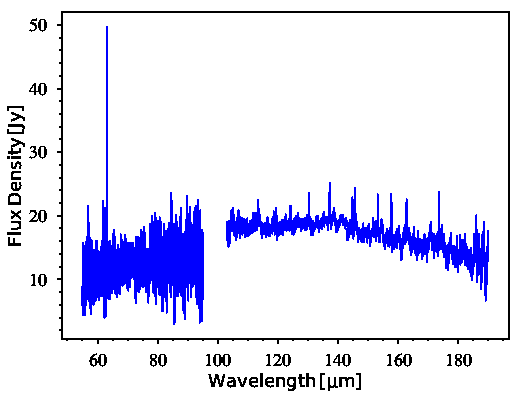

In [92]:
from wand.image import Image as WImage
print outdir+o[0]+'/pacs/data/'+o[0]+'_pacs_weighted.pdf'
img = WImage(filename=outdir+o[0]+'/pacs/data/'+o[0]+'_pacs_weighted.pdf')
img

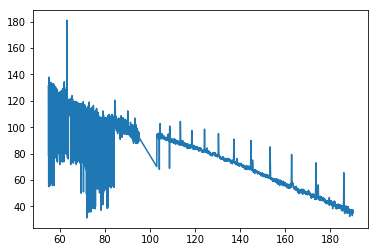

In [10]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
data = ascii.read('/home/bettyjo/yaolun/test/DKCha/pacs/data/DKCha_pacs_weighted.txt')
plt.plot(data['Wavelength(um)'], data['Flux_Density(Jy)'])

In [86]:
# inspect the pacs cube
o = obj_list[0]
cubefile = [pacsdatadir+o[1]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+o[1]+'_20hps3drbs_00.fits',
            pacsdatadir+o[1]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+o[1]+'_20hps3drrs_00.fits',
            pacsdatadir+o[2]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+o[2]+'_20hps3drbs_00.fits',
            pacsdatadir+o[2]+'/herschel.pacs.signal.PacsRebinnedCube/hpacs'+o[2]+'_20hps3drrs_00.fits']

from astropy.io import fits
import numpy as np
hdulist = fits.open(cubefile[0])

In [48]:
hdulist[1].header

XTENSION= 'IMAGE   '           / Java FITS: Mon Nov 14 16:43:49 CST 2016        
BITPIX  =                  -64                                                  
NAXIS   =                    3 / Dimensionality                                 
NAXIS1  =                    5                                                  
NAXIS2  =                    5                                                  
NAXIS3  =                 1732                                                  
PCOUNT  =                    0 / No extra parameters                            
GCOUNT  =                    1 / One group                                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywor

In [49]:
np.shape(hdulist[1].data)

(1732, 5, 5)

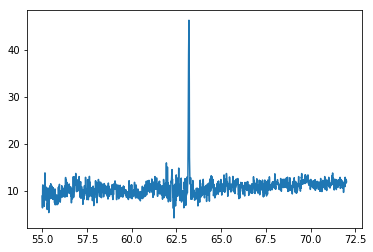

In [89]:
import matplotlib.pyplot as plt
spec = hdulist[1].data[:,2,2]*0
for i in range(1,4):
    for j in range(1,4):
        spec = spec + hdulist[1].data[:,i,j]
plt.plot(hdulist[8].data, spec)

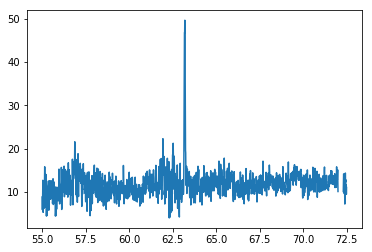

In [93]:
from astropy.io import ascii
data = ascii.read(outdir+o[0]+'/pacs/data/'+o[0]+'_pacs_weighted.txt')
plt.plot(data['Wavelength(um)'][data['Wavelength(um)'] <= 72.5], data['Flux_Density(Jy)'][data['Wavelength(um)'] <= 72.5])